# SDSS Performance Comparison | Hollis McLeod, Elijah Johnson

The following code is the product of the combined efforts of Hollis McLeod and Elijah Johnson for the term project in the Fall 2025 Section #22904 of AST4930 - Special Topics: Machine Learning at the University of Florida. This code is not for viewing, use, analysis, or any other purposes not in compliance with the [University of Florida Honor Code](https://policy.ufl.edu/regulation/4-040/). Violations will be reported accordingly.

## Overview

This Jupyter notebook defines a method for reading, processing, training machine learning models on, and visualizing results for [SDSS data](https://skyserver.sdss.org/dr19/SearchTools/sql) of the following form.

500,000 rows were downloaded as *SDSS.csv*, although 100,000 rows are planned for use. If computational power permits, however, more will be used for increased rigor of analysis.

**Fields**:
- Identification and standard features of astronomical objects (not used for training)
  - `objid`
  - `ra`
  - `dec`
  - `specobjid`
- Magnitudes
  - `u`
  - `g`
  - `r`
  - `i`
  - `z`
- Color indices (calculated)
  - `u-g`
  - `g-r`
  - `r-i`
  - `i-z`
- `redshift`
- `class`
  - "GALAXY"
  - "QSO" (shorthand for quasar)
  - "STAR"

**SQL Code**:
```
SELECT TOP 500000
p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z,
p.u-p.g as 'u-g', p.g-p.r as 'g-r', p.r-p.i as 'r-i', p.i-p.z as 'i-z',
s.specobjid, s.class, s.z as redshift
FROM PhotoObj AS p
JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE s.class IN ('GALAXY', 'QSO', 'STAR')
```

## Setup

### Install and Import Packages

In [ ]:
# Install if not already installed.
# %pip install pandas
# %pip install numpy
# %pip install scipy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install seaborn
# %pip install tensorflow

In [ ]:
# Consolidate all imports together for easy use.
import pandas as pd

import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

import tensorflow.keras as keras

# For capturing subprocess output with GridSearchCV parallelization
from joblib import parallel_backend # TODO: currently unused!

import matplotlib.pyplot as plt

import seaborn as sns

import pickle

import glob

### Define Paths and Constants

In [ ]:
# These paths are stored in a dictionary for easy access and non-verbosity
paths = {
    # location of SDSS data
    'data': './data/SDSS.csv',

    # base directories for saved graphs, charts, models
    'supervised_products': './products/supervised/',
    'unsupervised_products': './products/unsupervised/',

    # additional pathing for specific products
    'graphs': 'graphs/',
    'charts': 'charts/',
    'models': 'models/',
    'grid-searches': 'grid-searches/'
}

In [ ]:
# The number of rows to be used with the data
NROWS = 100000

# The column names of the features and the class from the dataset
FEATURES = ['u', 'g', 'r', 'i', 'z', 'u-g', 'g-r', 'r-i', 'i-z', 'redshift']
CLASS = 'class'

# The number of CPU cores we want to use for training, when possible. -1 means all that are available.
N_JOBS = -1

# Lists containing the names of the models in use.
SUPERVISED_MODELS = ['kNN', 'DT', 'SVM-C', 'RF-C', 'AdaBoost']
UNSUPERVISED_MODELS = ['k-means', 'GMM', 'DBSCAN', 'NN']

### Import Data and Perform Preliminary Processing

In [ ]:
data = pd.read_csv(paths['data'], nrows=NROWS)
data

In [ ]:
# Separate into X and Y
X = data[FEATURES].values
Y = data[CLASS]

CLASSES = np.unique(Y)

print(f'SHAPES:\n  -{X.shape}\n  -{Y.shape}')
print(f'CLASSES: {CLASSES}')

In [ ]:
# Split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

### Define Methods for Saving and Loading Model Information

In [96]:
# Helper function to extract the parameters of a model into a meaningful string for titles and filenames.
def get_model_and_model_str(gs, model_name=None):
    feature_str = ''
    model = None
    match model_name:
        case 'kNN':
            model = gs.best_estimator_[1]
            n_neighbors = gs.best_params_['kNN__n_neighbors']
            algo = gs.best_params_['kNN__algorithm']
            feature_str = f'(k={n_neighbors})(algorithm={algo})'
        case 'DT':
            model = gs.best_estimator_[0]
            m_d = gs.best_params_['DT__max_depth']
            crit = gs.best_params_['DT__criterion']
            feature_str = f'(max_depth={m_d})(criterion={crit})'
        case 'SVM-C':
            model = gs.best_estimator_[1]
            c = gs.best_params_['SVM-C__C']
            gamma = gs.best_params_['SVM-C__gamma']
            feature_str = f'(C={c})(gamma={gamma})'
        case 'RF-C':
            model = gs.best_estimator_[0]
            n_est = gs.best_params_['RF-C__n_estimators']
            feature_str = f'(n_estimators={n_est})'
        case 'AdaBoost':
            model = gs.best_estimator_[0]
            n_est = gs.best_params_['AdaBoost__n_estimators']
            learn_rate = gs.best_params_['AdaBoost__learning_rate']
            feature_str = f'(n_estimators={n_est})(learning_rate={learn_rate})'
        case _:
            raise ValueError('The \'model_name\' parameter cannot be unspecified. Please set \'model_name\' equal to \'kNN\', \'DT\', \'SVM-C\', \'RF-C\', or \'AdaBoost\'.')
        
    return model, model_name+feature_str

In [ ]:
# Determine the location for where a specific model is stored.
def getloc_for_pkl(model_name, isModel=True):
    loc = paths['supervised_products'] if model_name in SUPERVISED_MODELS \
                else paths['unsupervised_products'] if model_name in UNSUPERVISED_MODELS \
                else False
    if not loc: raise ValueError('The \'model_name\' parameter must be equal to one of the models in use. Please see SUPERVISED_MODELS and UNSUPERVISED_MODELS.')
    loc += paths['models'] if isModel else paths['grid-searches']
    return loc

# Save the model to a specific location with its features in its name.
def save_model(model, model_name, feature_str):
    loc = getloc_for_pkl(model_name)
    with open(f'{loc}{feature_str}.pkl', 'wb') as f:
        pickle.dump(model, f)

# Get the feature string of a filename.
def get_feature_str_from_filename(f):
    title = f.title()
    last_backslash_index = title.rfind('\\')
    filename = title[last_backslash_index + 1:]
    last_period_index = filename.rfind('.')
    feature_str = filename[:last_period_index]
    return feature_str

# Get a model from a specific location or by name. If by name, return the first result.
def load_model(pkl_name=None, model_name=None, return_feature_str=False):
    if model_name: loc = getloc_for_pkl(model_name)

    # Get the name of the .pkl file based on which parameter was provided.
    filename = glob.glob(f'{loc}{model_name}*.pkl' if model_name else pkl_name)[0]

    with open(filename, 'rb') as f: 
        return pickle.load(f) if not return_feature_str else pickle.load(f), get_feature_str_from_filename(filename)

In [69]:
# Save an entire grid search to a specific location
def save_grid_search(gs, model_name):
    model, feature_str = get_model_and_model_str(gs, model_name)
    loc = getloc_for_pkl(model_name, isModel=False)
    with open(f'{loc}GS_{feature_str}.pkl', 'wb') as f:
        pickle.dump(gs, f)

# Get a grid search from a specific location or by name. If by name, return the first result.
def load_grid_search(pkl_name=None, model_name=None, return_feature_str=False):
    if model_name: loc = getloc_for_pkl(model_name, isModel=False)
    
    # Get the name of the .pkl file based on which parameter was provided
    filename = glob.glob(f'{loc}GS_{model_name}*.pkl' if model_name else pkl_name)[0]
    print(f'Loading file {filename} for {('model_name=' + model_name) if model_name else ('pkl_name=' + pkl_name)}')

    with open(filename, 'rb') as f:
        return (pickle.load(f)) if not return_feature_str else (pickle.load(f), get_feature_str_from_filename(filename))

## Supervised Machine Learning

This section contains training, optimization, testing, and creation of products for the following supervised machine learning algorithms:

- k-Nearest Neighbors (kNN)
- Decision Tree (DT)
- Support Vector Machine Classifier (SVM-C)
- Random Forest Classifier (RF-C)
- Adaptive Boosting (AdaBoost) with Base DT

### Training Setup

Define parameter grids for each model for `cv=5`.

In [ ]:
CV = 5
SCALER = StandardScaler()

Define functions to create `Pipeline`s for each model, for experimentation and cleanliness. The default values for the hyperparameters may be tweaked and changed, since it is not necessary to risk overcompensating and wasting time for being unsure about what is needed. There will be sufficient evidence provided that the results of these parameters are indeed useful and meaningful, but the code required to determine sufficient ranges of hyperparameters and their respective outputs may not be included in the submission of this notebook.

Models requiring feature scaling include a scaler in their pipeline.

In [ ]:
# Produce a pipeline and parameter grid for kNN
def create_knn_for_grid_search(n_neighbors=np.arange(10)+1, algos=['auto']):
    pipe = Pipeline([
        ('scaler', SCALER), # kNN requires feature scaling!
        ('kNN', KNeighborsClassifier())
    ])

    param_grid = {
        'kNN__n_neighbors': n_neighbors,
        'kNN__algorithm': algos
    }

    return pipe, param_grid

In [ ]:
# Produce a pipeline and parameter grid for DT
def create_dt_for_grid_search(max_depth=np.arange(10)+1, criterion=['gini', 'entropy']):
    pipe = Pipeline([
        ('DT', DecisionTreeClassifier(random_state=0))
    ])

    param_grid = {
        'DT__max_depth': max_depth,
        'DT__criterion': criterion
    }

    return pipe, param_grid

In [ ]:
# Produce a pipeline and parameter grid for SVM-C
def create_svmc_for_grid_search(C=np.logspace(3, 6, num=4), gamma=np.logspace(-5, 0, num=4)):
    pipe = Pipeline([
        ('scaler', SCALER), # SVM requires feature scaling!
        ('SVM-C', SVC(kernel='rbf', random_state=0))
    ])

    param_grid = {
        'SVM-C__C': C,
        'SVM-C__gamma': gamma
    }

    return pipe, param_grid

In [85]:
# Produce a pipeline and parameter grid for RF-C
def create_rfc_for_grid_search(n_estimators=[100, 500, 1000, 5000]):
    pipe = Pipeline([
        ('RF-C', RandomForestClassifier(oob_score=True, random_state=0))
    ])

    param_grid = {
        'RF-C__n_estimators': n_estimators
    }

    return pipe, param_grid

In [ ]:
# Produce a pipeline and parameter grid for AdaBoost with Base DT.
def create_adaboost_for_grid_search(n_estimators=[10, 50, 100, 200], learning_rate=[0.001, 0.01, 0.1, 1.0], max_depth=1, criterion='gini'):
    # Per Worksheet 5, we want a poor base estimator for AdaBoost, so we default to max_depth=1 and criterion='gini.
    pipe = Pipeline([
        ('AdaBoost', AdaBoostClassifier(
            random_state=0,
            estimator=DecisionTreeClassifier(
                max_depth=max_depth,
                criterion=criterion)))
    ])

    param_grid = {
        'AdaBoost__n_estimators': n_estimators,
        'AdaBoost__learning_rate': learning_rate
    }

    return pipe, param_grid

Define a function to train models using a grid search with `CV` folds and `N_JOBS` cpu cores (defined above). This model takes the outputs of the functions above that produce pipelines and parameter grids for each type of supervised algorithm. This way, creating and training a model can be accomplished in just two lines! Given the volume of training and trial and error that will (likely) be needed, streamlining this process is essential for reducing headache. 

In [ ]:
# Train a grid search model on a pipeline and a parameter grid, printing the best results and returning the grid search.
def get_grid_search_results(pipe, param_grid, x_train=X_train, x_test=X_test, y_train=Y_train, y_test=Y_test, n_jobs=N_JOBS, cv=CV, r_t_s=True, verbose=3, save_model_to_pkl=True, save_gs_to_pkl=True):
    grid_search = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        return_train_score=r_t_s
    )

    grid_search.fit(x_train, y_train)

    if save_model_to_pkl:
        steps = list(pipe.named_steps.keys())
        m_name = steps[1] if steps[0] == 'scaler' else steps[0]
        m, ftr_str = get_model_and_model_str(grid_search, m_name)
        save_model(m, m_name, ftr_str)

    if save_gs_to_pkl:
        steps = list(pipe.named_steps.keys())
        m_name = steps[1] if steps[0] == 'scaler' else steps[0]
        save_grid_search(grid_search, m_name)

    print(f'Best Model: {grid_search.best_estimator_}')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Test Score: {grid_search.score(x_test, y_test)}')
    print(f"Mean Fit Time: {np.mean(grid_search.cv_results_['mean_fit_time'])}s") #TODO: look into creating a way to track every single fit time? this one sucks
    return grid_search

### Analysis Setup

#### General

For supervised models, we can create a plot of feature importances and a confusion matrix for each model. This way we can determine, on average, which features are the most important across the board and how well each model is determining class assignments.

In [ ]:
# Make a plot of feature importance using code adapted from the module 3 worksheet.
def plot_feature_importances_from_supervised_grid_search(gs, model_name=None, x_tr=X_train, x_te=X_test, y_tr=Y_train, y_te=Y_test, save=True, n_repeats=10):
    if model_name is None: raise ValueError('The \'model_name\' parameter cannot be unspecified. Please set \'model_name\' equal to \'kNN\', \'DT\', \'SVM-C\', \'RF-C\', or \'AdaBoost\'.')
    # Gather information about the model
    model, feature_str = get_model_and_model_str(gs, model_name=model_name)

    # Get actual feature importances
    model.fit(x_tr, y_tr)
    r = permutation_importance(model, x_te, y_te, n_repeats=n_repeats, random_state=0)

    n_features = len(FEATURES)
    plt.barh(np.arange(n_features), r.importances_mean, align='center')
    plt.yticks(np.arange(n_features), FEATURES)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.ylim(-1, n_features)

    # Add a title and save the plot
    plt.title(f'{model_name} SDSS Feature Importances {feature_str}')
    plt.tight_layout()
    if save: plt.savefig(paths['supervised_products'] + paths['charts'] + f'Feature_Importances_{feature_str}.png')
    plt.show()


In [ ]:
# Make a confusion matrix using the supervised grid_search's best estimator. Adapted from module 2 worksheet.
def confusion_matrix_from_grid_search(gs, model_name=None, x_te=X_test, y_te=Y_test, save=True):
    if model_name is None: raise ValueError('The \'model_name\' parameter cannot be unspecified. Please set \'model_name\' equal to \'kNN\', \'DT\', \'SVM-C\', \'RF-C\', or \'AdaBoost\'.')
    
    # Get information about the model
    model, feature_str = get_model_and_model_str(gs, model_name=model_name)

    cm = confusion_matrix(model.predict(x_te), y_te)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
    disp.plot(cmap='Blues')
    disp.ax_.set_title(f'Confusion Matrix for {model_name}{feature_str}')
    disp.figure_.tight_layout()
    if save: disp.figure_.savefig(paths['supervised_products'] + paths['charts'] + f'Confusion_Matrix_{feature_str}.png')
    plt.show()

#### kNN

For kNN models, we can create a plot of mean squared error against each attempted value for `n_neighbors` to visually understand why the best model was chosen.

In [ ]:
# Plot the test score as a function of n_neighbors. Adapted from module 4 worksheet.
def plot_test_score_vs_k_knn(gs_knn, save=True):
    model, feature_str = get_model_and_model_str(gs_knn, model_name='kNN')
    results = gs_knn.cv_results_['mean_test_score']
    n_neighbors = len(gs_knn.cv_results_['mean_test_score'])
    plt.scatter(np.arange(n_neighbors)+1, -results)
    plt.xlabel('n_neighbors')
    plt.ylabel('Test Score')
    plt.title(f'kNN Test Score as n_neighbors approaches {n_neighbors}')
    plt.xticks(np.arange(len(results)) + 1)
    plt.tight_layout()
    if save: plt.savefig(paths['supervised_products'] + paths['graphs'] + f'Test_Score_vs_k_{feature_str}.png')
    plt.show()

#### DT

For decision trees, we can optionally create a visual of the tree itself.

In [ ]:
# Print a visual tree of the best estimator
# TODO: may not be useful LOL
def plot_grid_search_DT(gs_dt):
    plot_tree(gs_dt.best_estimator_[0], feature_names=FEATURES, class_names=CLASSES)

#### SVM Classifier

In [ ]:
# TODO: examine homework 3 question 1.a and 1.b, determine how to reproduce this graph, ideally for both supervised and unsupervised algos

In [101]:
# Produce a heatmap for SVM classifiers and AdaBoost with DT Classifiers, since they both have two hyperparameters
def heatmap_from_gs(gs, model_name=None, save=True):
    model, feature_str = get_model_and_model_str(gs, model_name=model_name)
    results = pd.DataFrame(gs.cv_results_)

    # Create the grid
    keys = list(gs.param_grid.keys())
    axes = None
    if len(keys) == 2:
        axes = [gs.param_grid[keys[0]], gs.param_grid[keys[1]]]
    elif len(keys) == 3:
        keys = keys[1:]
        axes = [gs.param_grid[keys[0]], gs.param_grid[keys[1]]]
    else: raise ValueError("function heatmap() only works with 2-dimensional parameter grids. Please use a model with only two hyperparameters.")
    len_ax1 = len(axes[0])
    len_ax2 = len(axes[1])
    scores = np.array(results.mean_test_score).reshape(len_ax1, len_ax2).T

    # Create the actual heatmap, labeled properly with scores included
    ax = sns.heatmap(scores, annot=True, fmt=".2f",
                     xticklabels=np.array(axes[0]).astype(str),
                     yticklabels=np.array(axes[1]).astype(str))
    ax.set_xlabel(keys[0])
    ax.set_ylabel(keys[1])
    ax.set_title(f'Heatmap for {feature_str}')
    if save: ax.figure.savefig(paths['supervised_products'] + paths['charts'] + f'Heatmap_{feature_str}.png')
    ax.figure.show()

#### RF Classifier

There are no model-specific analysis products for the Random Forest Classifier.

#### AdaBoost Classifier with Base DT

There are no model-specific analysis products for the AdaBoost Classifier with Base DT.

### Model Training

This training run was performed on HiperGator, and the resulting `grid_search` objects were saved and loaded locally for analysis and improved training runs.

In [ ]:
# RUN ON HIPERGATOR
# pipe_knn, pg_knn = create_knn_for_grid_search()
# gs_knn = get_grid_search_results(pipe_knn, pg_knn)

In [ ]:
# RUN ON HIPERGATOR
# pipe_dt, pg_dt = create_dt_for_grid_search()
# gs_dt = get_grid_search_results(pipe_dt, pg_dt)

In [ ]:
# RUN ON HIPERGATOR
# pipe_svmc, pg_svmc = create_svmc_for_grid_search()
# gs_svmc = get_grid_search_results(pipe_svmc, pg_svmc)

In [ ]:
# RUN ON HIPERGATOR
# pipe_rfc, pg_rfc = create_rfc_for_grid_search()
# gs_rfc = get_grid_search_results(pipe_rfc, pg_rfc)

In [ ]:
# RUN ON HIPERGATOR
# pipe_adaboost, pg_adaboost = create_adaboost_for_grid_search()
# gs_adaboost = get_grid_search_results(pipe_adaboost, pg_adaboost)

### Creating Analysis Products

#### kNN

Loading file ./products/supervised/grid-searches\GS_kNN(k=3)(algorithm=auto).pkl for model_name=kNN


C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


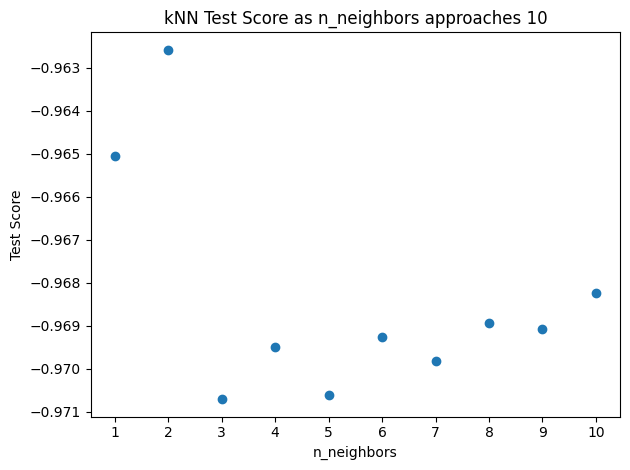

In [80]:
# DOWNLOADED FROM HIPERGATOR
hg_gs_knn, hg_knn_ftr_str = load_grid_search(model_name='kNN', return_feature_str=True)
plot_test_score_vs_k_knn(hg_gs_knn)

Awesome! We got what appears to be the best kNN model. No further training is needed, when examining that the .pkl file name indicates $\text{k}=3$ for this `grid_search`.

#### DT

In [81]:
# DOWNLOADED FROM HIPERGATOR
hg_gs_dt, hg_dt_ftr_str = load_grid_search(model_name='DT', return_feature_str=True)
hg_gs_dt.param_grid

Loading file ./products/supervised/grid-searches\GS_DT(max_depth=8)(criterion=entropy).pkl for model_name=DT


{'DT__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'DT__criterion': ['gini', 'entropy']}

There isn't much to do here, except to see that the parameter space has lent itself to an effective range of depths, and that the `grid_search` was able to find the best Decision Tree. Cool!

#### SVM-C

Loading file ./products/supervised/grid-searches\GS_SVM-C(C=1000.0)(gamma=0.021544346900318843).pkl for pkl_name=./products/supervised/grid-searches/*SVM-C(C=1000.0)(gamma=0.02*.pkl


C:\Users\Eli\AppData\Local\Temp\ipykernel_49008\3919712873.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


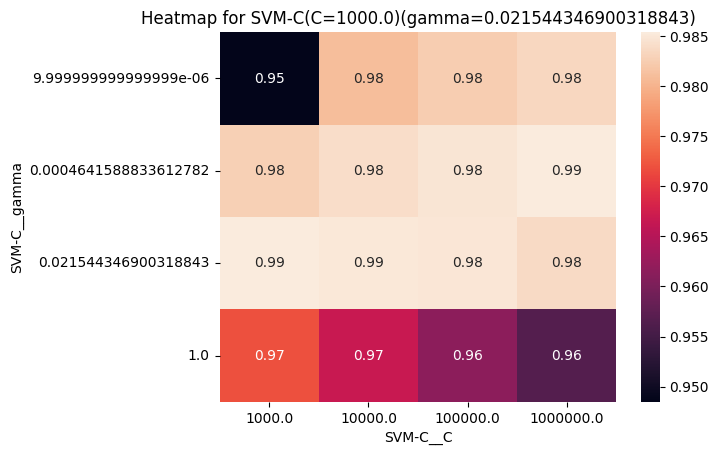

In [102]:
# DOWNLOADED FROM HIPERGATOR
path_svmc = paths['supervised_products'] + paths['grid-searches'] + '*SVM-C(C=1000.0)(gamma=0.02*.pkl'
hg_gs_svmc = load_grid_search(pkl_name=path_svmc)
heatmap_from_gs(hg_gs_svmc, 'SVM-C')

Given the above, it seems we can attempt to reduce our range for C to [$100, 1000, 10000$], and that the value of `SVM-C__gamma` is sitting around [$0.001, 0.01, 0.1$]. Let's run it again, also on HiperGator. 

This one easily took the longest to train. On a HiperGator session with 8 cores and 48 GB of memory, it took nearly an hour by itself. We messed up the first run due to some mislabeled code too, so we had to run it twice to get the first `grid_search` saved to a pickle file. Quite frustrating!

In [103]:
del hg_gs_svmc

In [75]:
# RUN ON HIPERGATOR
# pipe_svmc2, pg_svmc2 = create_svmc_for_grid_search(C=[100, 1000, 10000], gamma=[0.001, 0.01, 0.1])
# gs_svmc2 = get_grid_search_results(pipe=pipe_svmc2, param_grid=pg_svmc2)

Loading file ./products/supervised/grid-searches\GS_SVM-C(C=10000)(gamma=0.01).pkl for pkl_name=./products/supervised/grid-searches/GS_SVM-C(C=10000)*.pkl


C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Pack

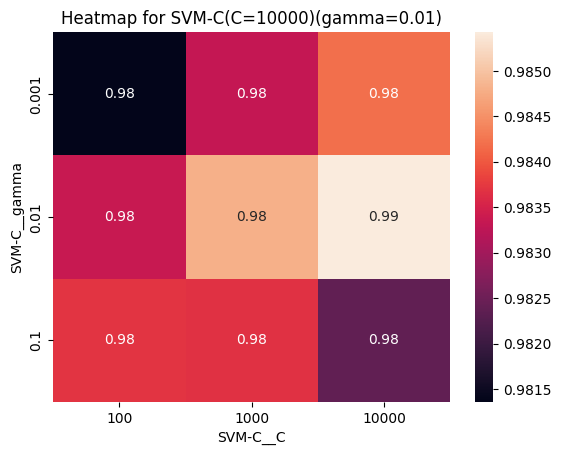

In [104]:
# DOWNLOADED FROM HIPERGATOR
path_svmc2 = paths['supervised_products'] + paths['grid-searches'] + 'GS_SVM-C(C=10000)*.pkl'
hg_gs_svmc2 = load_grid_search(pkl_name=path_svmc2)
heatmap_from_gs(hg_gs_svmc2, 'SVM-C')

Still looks like it could use some improvement... lets try another range.

In [105]:
del hg_gs_svmc2

In [78]:
# RUN ON HIPERGATOR
# pipe_svmc3, pg_svmc3 = create_svmc_for_grid_search(C=[10000, 100000, 1000000], gamma=[0.1, 0.01, 0.001])
# gs_svmc3 = get_grid_search_results(pipe=pipe_svmc3, param_grid=pg_svmc3)

In [ ]:
# DOWNLOADED FROM HIPERGATOR
path_svmc3 = paths['supervised_products'] + paths['grid-searches'] + '*SVM-C(C=)*.pkl'
hg_gs_svmc3 = load_grid_search(pkl_name=path_svmc3)
heatmap_from_gs(hg_gs_svmc3, 'SVM-C')

#### RF-C

In [92]:
# DOWNLOADED FROM HIPERGATOR
path_rfc = paths['supervised_products'] + paths['grid-searches'] + 'GS_RF-C(n_estimators=500).pkl'
hg_gs_rfc, hg_rfc_ftr_str = load_grid_search(model_name='RF-C', return_feature_str=True)

Loading file ./products/supervised/grid-searches\GS_RF-C(n_estimators=500).pkl for model_name=RF-C


In [93]:
print(hg_gs_rfc.param_grid)

{'RF-C__n_estimators': [100, 500, 1000, 5000]}


In this case, notably, $500$ estimators was the ideal amount. Let's see if we can't get that number smaller. We're going to drastically reduce the range and train it with HiperGator.

In [94]:
del hg_gs_rfc, hg_rfc_ftr_str

In [ ]:
# RUN ON HIPERGATOR
# pipe_rfc2, pg_rfc2 = create_rfc_for_grid_search(n_estimators=[475, 500, 525])
# gs_rfc2 = get_grid_search_results(pipe=pipe_rfc2, param_grid=pg_rfc2)

In [ ]:
# DOWNLOADED FROM HIPERGATOR
path_rfc2 = paths['supervised-products'] + paths['grid-searches'] + 'GS_RF-C()'
hg_gs_rfc2 = load_grid_search(pkl_name=path_rfc2)

#### AdaBoost

Loading file ./products/supervised/grid-searches/GS_AdaBoost(n_estimators=100)(learning_rate=0.1).pkl for pkl_name=./products/supervised/grid-searches/GS_AdaBoost(n_estimators=100)(learning_rate=0.1).pkl


C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator AdaBoostClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users

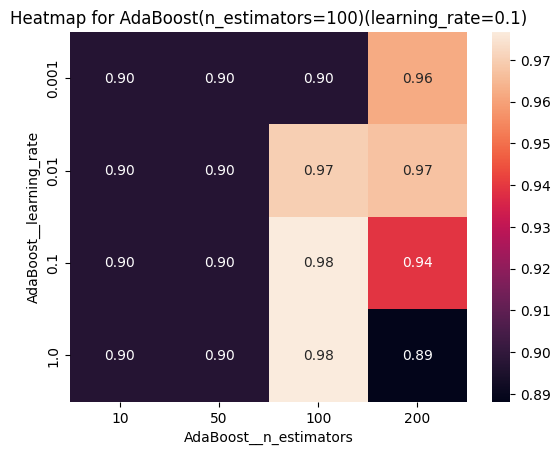

In [ ]:
# DOWNLOADED FROM HIPERGATOR
path_ada = paths['supervised_products'] + paths['grid-searches'] + 'GS_AdaBoost(n_estimators=100)(learning_rate=0.1).pkl'
hg_gs_adaboost = load_grid_search(pkl_name=path_ada)
heatmap_from_gs(hg_gs_adaboost, model_name='AdaBoost')

## Unsupervised Machine Learning

This section contains training, optimization, testing, and creation of products for the following unsupervised machine learning algorithms:

- k-Means Clustering (k-means)
- Gaussian Mixture Model (GMM) Clustering
- Density-Based Spatial Clustering of Applications with Noise (DBSCAN), using kNN for epsilon determination
- Neural Network (NN) with [XXXX] layers of [XXXX] nodes


### Training Setup

In [ ]:
# Produce a pipeline and parameter grid for kMeans
def create_kmeans_for_grid_search(n_clusters=len(CLASSES), n_init=10):
    pipe = Pipeline([
        ('scaler', SCALER), # k-Means requires feature scaling!
        ('k-means', KMeans(random_state=0))
    ])

    param_grid = {
        'k-means__n_clusters': n_clusters,
        'k-means__n_init': n_init
    }

    return pipe, param_grid

In [ ]:
# Produce a pipeline and parameter grid for GMM
def create_gmm_for_grid_search(n_components=len(CLASSES), n_init=10):
    pipe = Pipeline([
        ('scaler', SCALER), # GMM requires feature scaling!
        ('GMM', GaussianMixture(random_state=0))
    ])

    param_grid = {
        'GMM__n_components': n_components,
        'GMM__n_init': n_init
    }
    
    return pipe, param_grid

In [ ]:
# Produce a pipeline and parameter grid for DBSCAN
# TODO: include a k-nearest neighbors process in here for epsilon?
def create_dbscan_for_grid_search(eps=np.arange(0, 1, 0.1), min_samples=np.arange(5, 16)):
    pipe = Pipeline([
        ('scaler', SCALER), # DBSCAN requires feature scaling!
        ('DBSCAN', DBSCAN())
    ])

    param_grid = {
        'DBSCAN__eps': eps,
        'DBSCAN__min_samples': min_samples
    }

    return pipe, param_grid

In [ ]:
# TODO: setup for NN - include two or three activation functions, a few batch sizes maybe, maybe different gradient descents?


### Analysis Setup